# Uriel Isaac Álvarez Cárdenas

In [ ]:
%%capture
pip install transformers

In [ ]:
%%capture
pip install evaluate

In [ ]:
import evaluate
import pyarrow as pa
import requests
import json
import numpy as np
import os
import pandas as pd
import torch
from io import BytesIO
from typing import Tuple
from PIL import Image
from datasets import load_dataset, load_from_disk, Dataset, Features, Array3D
from transformers import AutoProcessor, ViTFeatureExtractor, ViTForImageClassification, Trainer, TrainingArguments, default_data_collator

In [ ]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dataset_path = '/content/drive/My Drive/datam/train'
val_dataset_path = '/content/drive/My Drive/datam/validation'
test_dataset_path = '/content/drive/My Drive/datam/test'

In [ ]:

def load_image(image_path):
    img = Image.open(image_path)
    return img

def create_dataset_from_folder(folder_path):
    images = []
    labels = []

    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):
            label = class_folder
            for filename in os.listdir(class_path):
                img_path = os.path.join(class_path, filename)
                img = load_image(img_path)
                images.append(img)
                labels.append(int(label))

    dataset = Dataset.from_dict({'image': images, 'label': labels})
    return dataset



train_dataset = create_dataset_from_folder(train_dataset_path)
val_dataset = create_dataset_from_folder(val_dataset_path)
test_dataset = create_dataset_from_folder(test_dataset_path)


In [ ]:
# Imprime la cantidad total de ejemplos en el dataset de validación
print(len(val_dataset))

# Imprime todas las claves (columnas) disponibles en el dataset de validación
print(val_dataset.column_names)

# Acceder a una fila específica, por ejemplo, el primer ejemplo en el dataset de validación
print(val_dataset[0])

# Acceder a un valor específico en una columna y fila, por ejemplo, el valor de la columna 'label' del primer ejemplo en el dataset de validación
print(val_dataset['label'][0])

1026
['image', 'label']
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7C495EA942E0>, 'label': 2}
2


In [ ]:
ex = val_dataset[400]
ex

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7C495EA94280>,
 'label': 4}

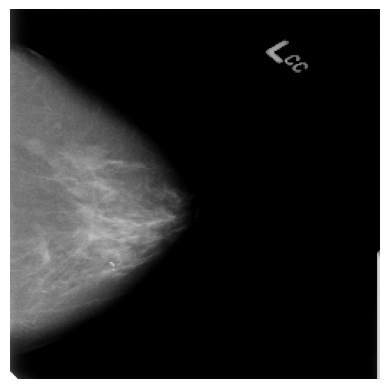

In [ ]:
import matplotlib.pyplot as plt

def show_image(img_array):
    plt.imshow(img_array)
    plt.axis('off')  # Para no mostrar los ejes
    plt.show()

# Ahora puedes mostrar una imagen del dataset 'val_dataset' en lugar de su representación numérica
ex = val_dataset[100]['image']
show_image(ex)

In [ ]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
feature_extractor(ex, return_tensors='pt')

{'pixel_values': tensor([[[[-0.6706, -0.7255, -0.7725,  ..., -0.9608, -0.9451, -0.9216],
          [-0.6863, -0.7490, -0.7961,  ..., -0.9765, -0.9686, -0.9451],
          [-0.6941, -0.7569, -0.8039,  ..., -0.9843, -0.9765, -0.9608],
          ...,
          [ 1.0000,  0.8353,  0.0039,  ..., -0.9059,  0.2235,  0.6706],
          [ 1.0000,  1.0000,  0.8275,  ..., -0.8980,  0.2235,  0.6784],
          [ 1.0000,  1.0000,  1.0000,  ..., -0.8902,  0.2314,  0.6706]],

         [[-0.6706, -0.7255, -0.7725,  ..., -0.9608, -0.9451, -0.9216],
          [-0.6863, -0.7490, -0.7961,  ..., -0.9765, -0.9686, -0.9451],
          [-0.6941, -0.7569, -0.8039,  ..., -0.9843, -0.9765, -0.9608],
          ...,
          [ 1.0000,  0.8353,  0.0039,  ..., -0.9059,  0.2235,  0.6706],
          [ 1.0000,  1.0000,  0.8275,  ..., -0.8980,  0.2235,  0.6784],
          [ 1.0000,  1.0000,  1.0000,  ..., -0.8902,  0.2314,  0.6706]],

         [[-0.6706, -0.7255, -0.7725,  ..., -0.9608, -0.9451, -0.9216],
          [-0

In [ ]:
# Name of model as named in the HuggingFace Hub
model_name = "google/vit-base-patch16-224-in21k"

In [ ]:
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

In [ ]:
def process_examples(examples, image_processor):
    """Processor helper function. Used to process batches of images using the
    passed image_processor.

    Parameters
    ----------
    examples
        A batch of image examples.

    image_processor
        A HuggingFace image processor for the selected model.

    Returns
    -------
    examples
        A batch of processed image examples.
    """

    # Get batch of images
    images = examples['image']

    # Preprocess
    inputs = image_processor(images=images)
    # Add pixel_values
    examples['pixel_values'] = inputs['pixel_values']

    return examples


def apply_processing(
    model_name: str,
    train_dataset: Dataset,
    val_dataset: Dataset,
    test_dataset: Dataset
) -> Tuple[Dataset, Dataset, Dataset]:
    """
    Apply model's image AutoProcessor to transform train, validation and test subsets.
    Returns train, validation and test datasets with `pixel_values` in torch tensor type.
    """

    # Extend the features
    features = Features({
        **train_dataset.features,
        'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    })

    # Instantiate image_processor
    image_processor = AutoProcessor.from_pretrained(model_name)

    # Preprocess images
    train_dataset = train_dataset.map(process_examples, batched=True, features=features, fn_kwargs={"image_processor": image_processor})
    val_dataset = val_dataset.map(process_examples, batched=True, features=features, fn_kwargs={"image_processor": image_processor})
    test_dataset = test_dataset.map(process_examples, batched=True, features=features, fn_kwargs={"image_processor": image_processor})

    # Set to torch format for training
    train_dataset.set_format('torch', columns=['pixel_values', 'label'])
    val_dataset.set_format('torch', columns=['pixel_values', 'label'])
    test_dataset.set_format('torch', columns=['pixel_values', 'label'])

    # Remove unused column
    train_dataset = train_dataset.remove_columns("image")
    val_dataset = val_dataset.remove_columns("image")
    test_dataset = test_dataset.remove_columns("image")

    return train_dataset, val_dataset, test_dataset


# Apply AutoProcessor
train_dataset, val_dataset, test_dataset = apply_processing(model_name,
train_dataset, val_dataset, test_dataset)



Map:   0%|          | 0/8186 [00:00<?, ? examples/s]

Map:   0%|          | 0/1026 [00:00<?, ? examples/s]

Map:   0%|          | 0/1027 [00:00<?, ? examples/s]

In [ ]:
num_classes = 6

# Download model from model hub
model = ViTForImageClassification.from_pretrained(model_name, num_labels=num_classes)

# Download feature extractor from hub
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# K for top accuracy metric
k_for_top_acc = 3

# Compute metrics function for binary classification
acc_metric = evaluate.load("accuracy", module_type="metric")

def compute_metrics(eval_pred):
    predicted_probs, labels = eval_pred
    # Accuracy
    predicted_labels = np.argmax(predicted_probs, axis=1)
    acc = acc_metric.compute(predictions=predicted_labels, references=labels)
    # Top-K Accuracy
    top_k_indexes = [np.argpartition(row, -k_for_top_acc)[-k_for_top_acc:] for row in predicted_probs]
    top_k_classes = [top_k_indexes[i][np.argsort(row[top_k_indexes[i]])] for i, row in enumerate(predicted_probs)]
    top_k_classes = np.flip(np.array(top_k_classes), 1)
    acc_k = {
        f"accuracy_k" : sum([label in predictions for predictions, label in zip(top_k_classes, labels)]) / len(labels)
    }
    # Merge metrics
    acc.update(acc_k)
    return acc

In [ ]:
# Imprime la cantidad total de ejemplos en el dataset de validación
print(len(train_dataset))

# Imprime todas las claves (columnas) disponibles en el dataset de validación
print(train_dataset.column_names)

# Acceder a una fila específica, por ejemplo, el primer ejemplo en el dataset de validación
print(train_dataset[0])

# Acceder a un valor específico en una columna y fila, por ejemplo, el valor de la columna 'label' del primer ejemplo en el dataset de validación
print(train_dataset['label'][0])

8186
['label', 'pixel_values']
{'label': tensor(5), 'pixel_values': tensor([[[-0.2784, -0.2863, -0.2863,  ..., -0.3333, -0.2706,  0.6157],
         [-0.8824, -0.8902, -0.9059,  ..., -0.5608, -0.5059, -0.3725],
         [-0.9922, -1.0000, -1.0000,  ..., -0.7412, -0.6941, -0.6078],
         ...,
         [-0.0510, -0.0667, -0.0745,  ...,  0.1137,  0.3255,  0.8275],
         [ 0.1373,  0.1451,  0.1294,  ...,  0.5529,  0.8118,  0.9765],
         [ 0.3098,  0.3098,  0.3020,  ...,  0.8824,  0.9922,  1.0000]],

        [[-0.2784, -0.2863, -0.2863,  ..., -0.3333, -0.2706,  0.6157],
         [-0.8824, -0.8902, -0.9059,  ..., -0.5608, -0.5059, -0.3725],
         [-0.9922, -1.0000, -1.0000,  ..., -0.7412, -0.6941, -0.6078],
         ...,
         [-0.0510, -0.0667, -0.0745,  ...,  0.1137,  0.3255,  0.8275],
         [ 0.1373,  0.1451,  0.1294,  ...,  0.5529,  0.8118,  0.9765],
         [ 0.3098,  0.3098,  0.3020,  ...,  0.8824,  0.9922,  1.0000]],

        [[-0.2784, -0.2863, -0.2863,  ..., -0.33

In [ ]:
train_dataset.features["label"]

Value(dtype='int64', id=None)

In [ ]:
train_dataset["label"]

tensor([5, 5, 5,  ..., 1, 1, 1])

In [ ]:
model_dir = "/content/drive/My Drive/datam/model"
output_data_dir = "/content/drive/My Drive/datam/outputs"

# Total number of training epochs to perform
num_train_epochs = 15
# The batch size per GPU/TPU core/CPU for training
per_device_train_batch_size = 32
# The batch size per GPU/TPU core/CPU for evaluation
per_device_eval_batch_size = 64
# The initial learning rate for AdamW optimizer
learning_rate = 2e-5
# Number of steps used for a linear warmup from 0 to learning_rate
warmup_steps = 500
# The weight decay to apply to all layers except all bias and LayerNorm weights in AdamW optimizer
weight_decay = 0.01

main_metric_for_evaluation = "accuracy"

In [ ]:
%%capture
pip install transformers[torch]

In [ ]:
%%capture
pip install accelerate -U

In [ ]:
# Define training args
training_args = TrainingArguments(
    output_dir = model_dir,
    num_train_epochs = num_train_epochs,
    per_device_train_batch_size = per_device_train_batch_size,
    per_device_eval_batch_size = per_device_eval_batch_size,
    warmup_steps = warmup_steps,
    weight_decay = weight_decay,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    logging_strategy = "epoch",
    logging_dir = f"{output_data_dir}/logs",
    learning_rate = float(learning_rate),
    load_best_model_at_end = True,
    metric_for_best_model = main_metric_for_evaluation,
)

# Create Trainer instance
trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    data_collator = default_data_collator,
    tokenizer = feature_extractor
)


In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Accuracy K
1,1.544400,1.324870,0.523392,0.866472
2,1.237900,1.168163,0.564327,0.915205
3,1.078100,1.101241,0.579922,0.931774
4,0.952600,1.060222,0.598441,0.929825
5,0.835900,1.091371,0.585770,0.932749
6,0.724800,1.092884,0.586745,0.931774
7,0.604200,1.160370,0.578947,0.921053
8,0.487600,1.209874,0.576023,0.917154
9,0.382100,1.293455,0.567251,0.901559
10,0.299200,1.398992,0.561404,0.879142


TrainOutput(global_step=3840, training_loss=0.5952274555961291, metrics={'train_runtime': 5004.2646, 'train_samples_per_second': 24.537, 'train_steps_per_second': 0.767, 'total_flos': 9.515582533171814e+18, 'train_loss': 0.5952274555961291, 'epoch': 15.0})

In [ ]:
log_history = pd.DataFrame(trainer.state.log_history)
log_history = log_history.fillna(0)
log_history = log_history.groupby(['epoch']).sum()
log_history

,loss,learning_rate,step,eval_loss,eval_accuracy,eval_accuracy_k,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,
1.0,1.5444,0.000010,512,1.324870,0.523392,0.866472,12.0202,85.357,1.414,0.0000,0.000,0.000,0.000000e+00,0.000000
2.0,1.2379,0.000020,1024,1.168163,0.564327,0.915205,11.9124,86.129,1.427,0.0000,0.000,0.000,0.000000e+00,0.000000
3.0,1.0781,0.000018,1536,1.101241,0.579922,0.931774,11.9328,85.982,1.425,0.0000,0.000,0.000,0.000000e+00,0.000000
4.0,0.9526,0.000017,2048,1.060222,0.598441,0.929825,11.8582,86.523,1.434,0.0000,0.000,0.000,0.000000e+00,0.000000
5.0,0.8359,0.000015,2560,1.091371,0.585770,0.932749,11.9670,85.736,1.421,0.0000,0.000,0.000,0.000000e+00,0.000000
6.0,0.7248,0.000014,3072,1.092884,0.586745,0.931774,12.0283,85.299,1.413,0.0000,0.000,0.000,0.000000e+00,0.000000
7.0,0.6042,0.000012,3584,1.160370,0.578947,0.921053,11.8957,86.249,1.429,0.0000,0.000,0.000,0.000000e+00,0.000000
8.0,0.4876,0.000011,4096,1.209874,0.576023,0.917154,11.9428,85.910,1.423,0.0000,0.000,0.000,0.000000e+00,0.000000
9.0,0.3821,0.000009,4608,1.293455,0.567251,0.901559,11.9241,86.044,1.426,0.0000,0.000,0.000,0.000000e+00,0.000000


import numpy as np
from google.colab import autoviz
df_3300001089887432233 = autoviz.get_df('df_3300001089887432233')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_3300001089887432233, *['loss'], **{})
chart

import numpy as np
from google.colab import autoviz
df_2868155276555442973 = autoviz.get_df('df_2868155276555442973')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_2868155276555442973, *['learning_rate'], **{})
chart

import numpy as np
from google.colab import autoviz
df_421521602421219398 = autoviz.get_df('df_421521602421219398')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_421521602421219398, *['step'], **{})
chart

import numpy as np
from google.colab import autoviz
df_5126702691601784113 = autoviz.get_df('df_5126702691601784113')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_5126702691601784113, *['eval_loss'], **{})
chart

import numpy as np
from google.colab import autoviz
df_1546972885083734381 = autoviz.get_df('df_1546972885083734381')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_1546972885083734381, *['loss'], **{})
chart

import numpy as np
from google.colab import autoviz
df_2044977538833883109 = autoviz.get_df('df_2044977538833883109')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_2044977538833883109, *['learning_rate'], **{})
chart

import numpy as np
from google.colab import autoviz
df_8596638501533833090 = autoviz.get_df('df_8596638501533833090')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_8596638501533833090, *['step'], **{})
chart

import numpy as np
from google.colab import autoviz
df_3355641705577058700 = autoviz.get_df('df_3355641705577058700')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_3355641705577058700, *['eval_loss'], **{})
chart

import numpy as np
from google.colab import autoviz
df_8250777409286186875 = autoviz.get_df('df_8250777409286186875')

def scatter_plots(df, colname_pairs, scatter_plot_size=2.5, size=8, alpha=.6):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * scatter_plot_size, scatter_plot_size))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    ax.scatter(df[x_colname], df[y_colname], s=size, alpha=alpha)
    plt.xlabel(x_colname)
    plt.ylabel(y_colname)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df_8250777409286186875, *[[['loss', 'learning_rate'], ['learning_rate', 'step'], ['step', 'eval_loss'], ['eval_loss', 'eval_accuracy']]], **{})
chart

import numpy as np
from google.colab import autoviz
df_1625914661169020860 = autoviz.get_df('df_1625914661169020860')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_1625914661169020860, *['eval_runtime', 'loss', None], **{})
chart

import numpy as np
from google.colab import autoviz
df_791060385729790674 = autoviz.get_df('df_791060385729790674')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_791060385729790674, *['eval_runtime', 'learning_rate', None], **{})
chart

import numpy as np
from google.colab import autoviz
df_8721851559680899751 = autoviz.get_df('df_8721851559680899751')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_8721851559680899751, *['eval_runtime', 'eval_loss', None], **{})
chart

import numpy as np
from google.colab import autoviz
df_8983537587838434725 = autoviz.get_df('df_8983537587838434725')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_8983537587838434725, *['eval_runtime', 'eval_accuracy', None], **{})
chart

import numpy as np
from google.colab import autoviz
df_8624076435937865857 = autoviz.get_df('df_8624076435937865857')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_8624076435937865857, *['loss'], **{})
chart

import numpy as np
from google.colab import autoviz
df_6026645323778984673 = autoviz.get_df('df_6026645323778984673')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_6026645323778984673, *['learning_rate'], **{})
chart

import numpy as np
from google.colab import autoviz
df_8128974114886578951 = autoviz.get_df('df_8128974114886578951')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_8128974114886578951, *['step'], **{})
chart

import numpy as np
from google.colab import autoviz
df_8429571944812192000 = autoviz.get_df('df_8429571944812192000')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_8429571944812192000, *['eval_loss'], **{})
chart

import numpy as np
from google.colab import autoviz
df_4531193333215920904 = autoviz.get_df('df_4531193333215920904')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_4531193333215920904, *['loss'], **{})
chart

import numpy as np
from google.colab import autoviz
df_7594594219943494029 = autoviz.get_df('df_7594594219943494029')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_7594594219943494029, *['learning_rate'], **{})
chart

import numpy as np
from google.colab import autoviz
df_1856940084575165756 = autoviz.get_df('df_1856940084575165756')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_1856940084575165756, *['step'], **{})
chart

import numpy as np
from google.colab import autoviz
df_777957355321312388 = autoviz.get_df('df_777957355321312388')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_777957355321312388, *['eval_loss'], **{})
chart

import numpy as np
from google.colab import autoviz
df_1511614103623668859 = autoviz.get_df('df_1511614103623668859')

def scatter_plots(df, colname_pairs, scatter_plot_size=2.5, size=8, alpha=.6):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * scatter_plot_size, scatter_plot_size))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    ax.scatter(df[x_colname], df[y_colname], s=size, alpha=alpha)
    plt.xlabel(x_colname)
    plt.ylabel(y_colname)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df_1511614103623668859, *[[['loss', 'learning_rate'], ['learning_rate', 'step'], ['step', 'eval_loss'], ['eval_loss', 'eval_accuracy']]], **{})
chart

import numpy as np
from google.colab import autoviz
df_7421542352631699667 = autoviz.get_df('df_7421542352631699667')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_7421542352631699667, *['eval_runtime', 'loss', None], **{})
chart

import numpy as np
from google.colab import autoviz
df_7173907453059364999 = autoviz.get_df('df_7173907453059364999')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_7173907453059364999, *['eval_runtime', 'learning_rate', None], **{})
chart

import numpy as np
from google.colab import autoviz
df_688000576349312502 = autoviz.get_df('df_688000576349312502')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_688000576349312502, *['eval_runtime', 'eval_loss', None], **{})
chart

import numpy as np
from google.colab import autoviz
df_6141807467927937457 = autoviz.get_df('df_6141807467927937457')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_6141807467927937457, *['eval_runtime', 'eval_accuracy', None], **{})
chart

array([<Axes: xlabel='epoch'>, <Axes: xlabel='epoch'>,
       <Axes: xlabel='epoch'>, <Axes: xlabel='epoch'>], dtype=object)

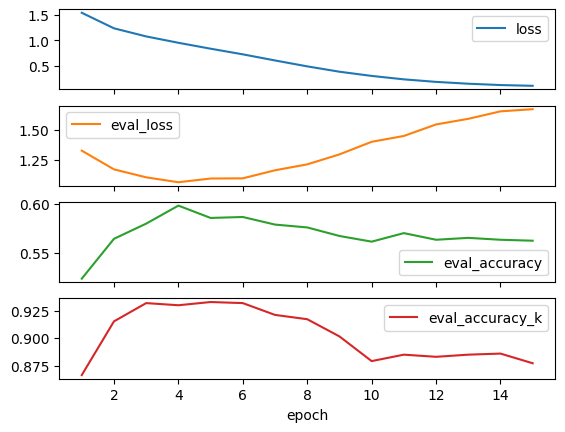

In [ ]:
log_history[["loss", "eval_loss", "eval_accuracy",
"eval_accuracy_k"]].plot(subplots=True)

In [ ]:
trainer.save_model(model_dir)

In [ ]:


# Load trained model
model = ViTForImageClassification.from_pretrained(model_dir)

# Load feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained(model_dir)

# Create Trainer instance
trainer = Trainer(
    model=model,
    compute_metrics=compute_metrics,
    data_collator=default_data_collator,
    tokenizer=feature_extractor
)

# Evaluate model
eval_results = trainer.evaluate(eval_dataset=test_dataset)

# Writes eval_result to file which can be accessed later
with open(os.path.join(output_data_dir, "eval_results.json"), "w") as writer:
    print(f"Logging evaluation results at {output_data_dir}/eval_results.json")
    writer.write(json.dumps(eval_results))

print(json.dumps(eval_results, indent=4))

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Logging evaluation results at /content/drive/My Drive/datam/outputs/eval_results.json
{
    "eval_loss": 1.0648765563964844,
    "eval_accuracy": 0.6105160662122687,
    "eval_accuracy_k": 0.9143135345666992,
    "eval_runtime": 12.9646,
    "eval_samples_per_second": 79.216,
    "eval_steps_per_second": 9.95
}
